In [5]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.volume import MFIIndicator 
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator
from ta.trend import MACD, CCIIndicator
from ta.volatility import BollingerBands
import warnings
warnings.filterwarnings('ignore')

In [6]:
# import sys 
# sys.path.append('C:\python\ps\duahettienday\Gui_Huy')
# from get_data_vn import get_data_ps

In [7]:
# data = get_data_ps(10000)

In [8]:
# data.set_index('Date').Close.plot(figsize = (18,6))

In [9]:
from scipy import signal
from scipy.signal import butter,lfilter 


def lowpass_filter_period_only(x, cutoff_period: int = 20, order: int = 2, zero_phase: bool = False):
    cutoff_period = max(int(cutoff_period), 3)  # kẹp tối thiểu 3
    Wn = 2.0 / float(cutoff_period)
    Wn = min(max(Wn, 1e-6), 0.999999)          # đảm bảo (0,1)
    sos = butter(order, Wn, btype="low", output="sos")
    if zero_phase:
        y = signal.sosfiltfilt(sos, pd.Series(x).values, method="gust")
    else:
        y = signal.sosfilt(sos, pd.Series(x).values)
    return pd.Series(y, index=pd.Series(x).index)


In [10]:
#path to expiration_date file
df = pd.read_csv('expiration_date.csv') 
df['Date'] = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))

In [11]:
# import sys#Thay Z bằng tên ổ nas máy cá nhân
# sys.path.append('Z:\Data\API_Chien')
# from get_data_vn import get_data_ps
# #Lấy dữ liệu phái sinh
# data=get_data_ps(3000)
# data = data.set_index("Date")
# data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
# data = data.reset_index() 

In [12]:
# data

In [13]:
# data.to_csv('data1min.csv')

In [14]:
data = pd.read_csv('.\data1mins.csv')

In [15]:
data.Date = pd.to_datetime(data.Date, errors='coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index() 

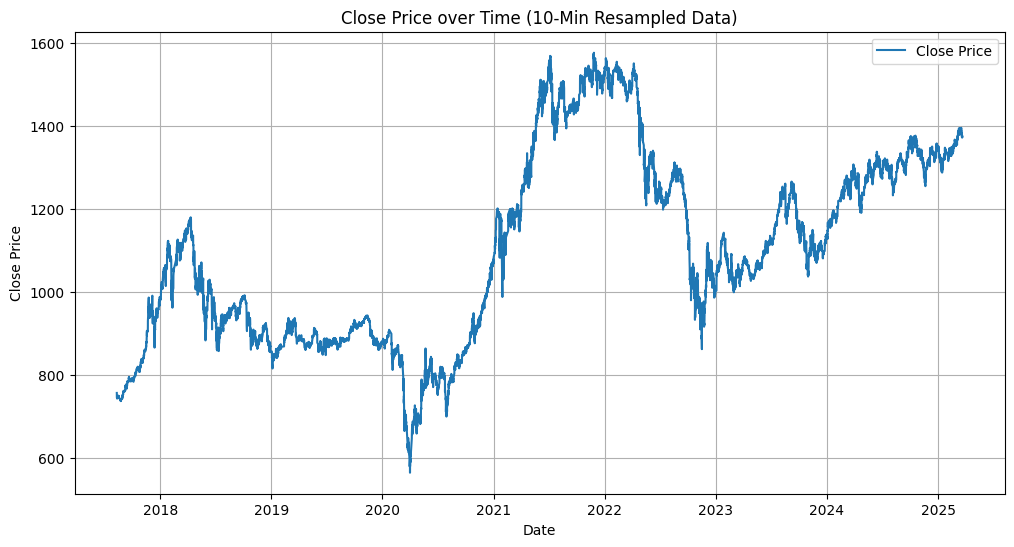

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(data['Date'], data['Close'], label='Close Price')
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Close Price over Time (10-Min Resampled Data)")
plt.legend()
plt.grid(True)
plt.show()


In [17]:
# Nguyên tắc xây dựng mô hình
# 1. 1 chỉ báo xu hướng + 1 chỉ báo momentum + 1 chỉ báo biến động/volume là đủ → tránh overfitting.
# 2. Thêm Price Action để lọc tín hiệu cuối cùng (ví dụ: chỉ vào lệnh khi có Pin Bar/Engulfing tại hỗ trợ/kháng cự).
# 3. Backtest & Optimization: mỗi thị trường (stock, crypto, forex) và mỗi timeframe sẽ cần tinh chỉnh khác nhau.
# 4. Risk Management: ATR để set SL, fixed RR (risk/reward ratio) để chốt lời.

In [18]:
# Trend Indicators

In [19]:
# AverageTrueRange, CCIIndicator, IchimokuIndicator, MACD, RSI, ADXIndicator, MFI, stochastic,
def alpha(data, params):
    data['Close_filtered'] = lowpass_filter_period_only(data['Close'], params['t1'])
    #tính chỉ báo 
    data['MFI'] = MFIIndicator(high = data['High'], low = data['Low'], close = data['Close'], volume = data['Volume'], window=params['w1']).money_flow_index()#.w1: của sổ của chỉ báo
    #
    
    pos = 0
    position = []
    for i in range(len(data)):
        #
        MFI = data['MFI'].values[i]
        #
        if pos == 0:
            #điều kiện enter short
            if MFI < params['t2']:#13. threshold to enter short 30
                pos = -1
            #điều kiện vào long
            if MFI > params['t3']:#81. threshold to enter long 70
                pos = 1
        elif pos == -1:
            #thoát short
            if MFI > params['t4']:#59. threshold to exit short
                pos = 0
        else:
            #thoát long
            if MFI < params['t5']:#37. threshold to exit long
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 25):
            #thoát short cuối ngày(CÓ THỂ HOẶC KHÔNG)
            if pos == - 1:
                pos = 0
        if data['Date'].iloc[i].time() == datetime.time(14, 45):
            if len(position) > 0:
                #reset vị thế ngày đáo hạn
                if data['Date'].iloc[i].date() in expiration_date:
                    pos = 0

        position.append(pos)
    #mục đích cuối cùng vẫn là cột pos(position)
    data['pos'] = position
    return data
#CÁC ĐIỀU KIỆN CÓ TRÊN LÀ NHỮNG ĐIỀU KIỆN ĐƠN SƠ, ĐỂ CÓ 1 ALPHA TỐT, RESEARCHER CẦN NGHIÊN CỨU VÀ ADD THÊM CÁC ĐIỀU KIỆN KHÁC

In [20]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [21]:
import pandas as pd

In [22]:
params = {'t1': 0.75, 't2': 13, 't3': 81, 't4': 59, 't5': 37, 'w1': 14, 'w2': 14}
ds = alpha(data, params)

In [23]:
ds

Loading ITables v2.5.2 from the internet... (need help?)


In [24]:
import warnings
warnings.filterwarnings("ignore")

Margin: 17.08
MDD: 70.4 (4.52%)

   Total trading quantity: 538
         Profit per trade: 3.44
             Total Profit: 2055.5
         Profit after fee: 1848.3
 Trading quantity per day: 0.28
 Profit per day after fee: 0.97
                   Return: 0.16
          Profit per year: 242.59
                  HitRate: 0.51
          HitRate per day: 0.3


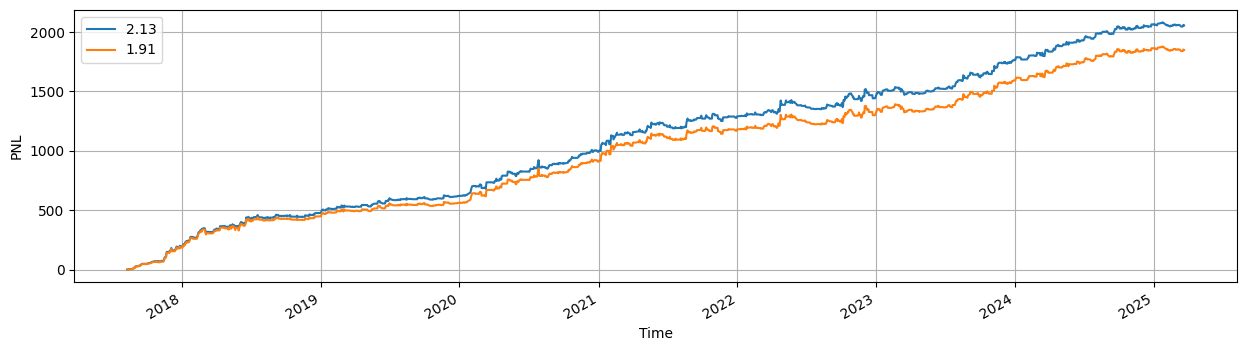

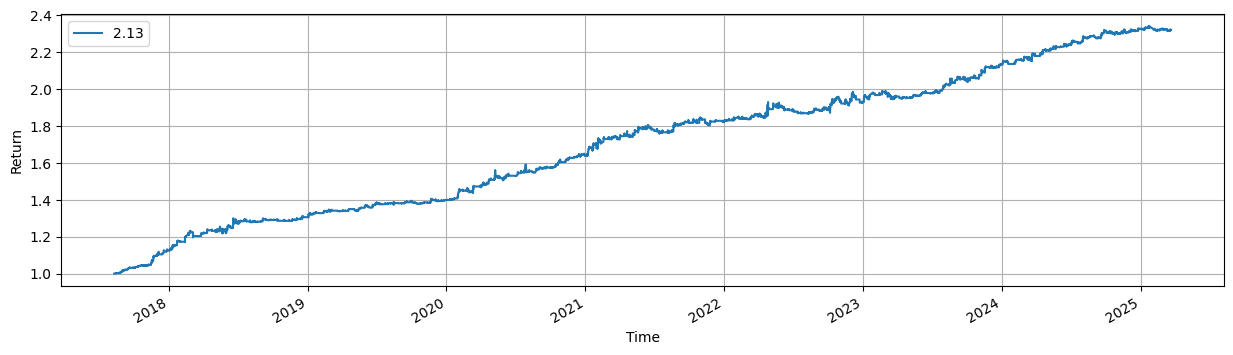

In [25]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [26]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [27]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)
